In [1]:
!pip install opencv-python

In [2]:

from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [3]:

DATA_FOLDER = 'C:/Users/91995/Music/deepfake/deepfake/dataset'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

train samples: 168
test samples: 171


In [4]:
train_sample_metadata = pd.read_json('C:/Users/91995/Music/deepfake/deepfake/dataset/train_sample_videos/metadata.json').T
train_sample_metadata.head()

label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

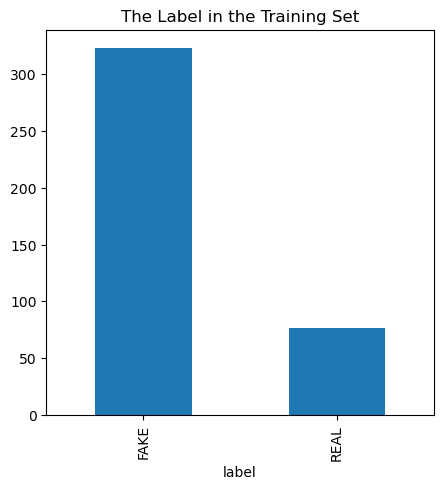

In [5]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(5,5),kind='bar',title='The Label in the Training Set')
plt.show()

In [6]:
train_sample_metadata.shape

(400, 3)

In [7]:
f_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(5).index)
f_train_sample_video

['aklqzsddfl.mp4',
 'arlmiizoob.mp4',
 'abofeumbvv.mp4',
 'azpuxunqyo.mp4',
 'cettndmvzl.mp4']

In [8]:
def capture_image_from_video(video_path):
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    #print(frame)
    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

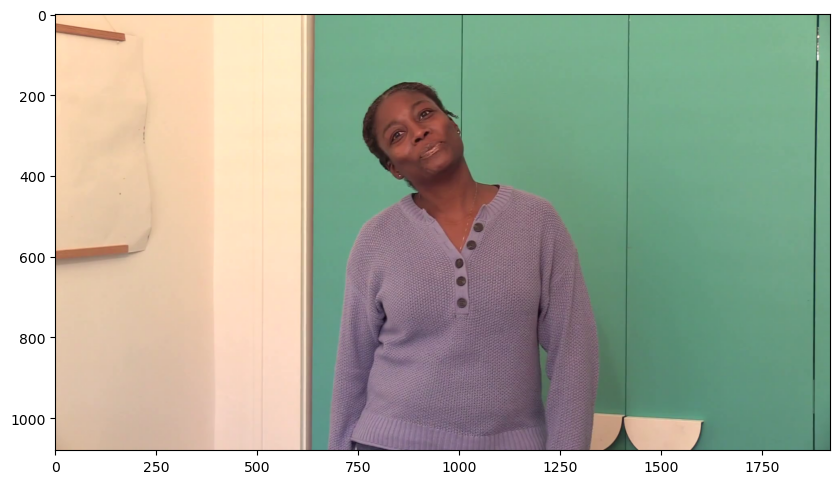

In [9]:
#for video_file in f_train_sample_video:
#capture_image_from_video(os.path.join('C:/Users/91995/Music/deepfake/deepfake/dataset/train_sample_videos','dvakowbgbt.mp4'))
capture_image_from_video('C:/Users/91995/Music/deepfake/deepfake/dataset/train_sample_videos/abarnvbtwb.mp4')

In [10]:
r_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(5).index)
r_train_sample_video

['cppdvdejkc.mp4',
 'bxzakyopjf.mp4',
 'eggbjzxnmg.mp4',
 'dkzvdrzcnr.mp4',
 'cprhtltsjp.mp4']

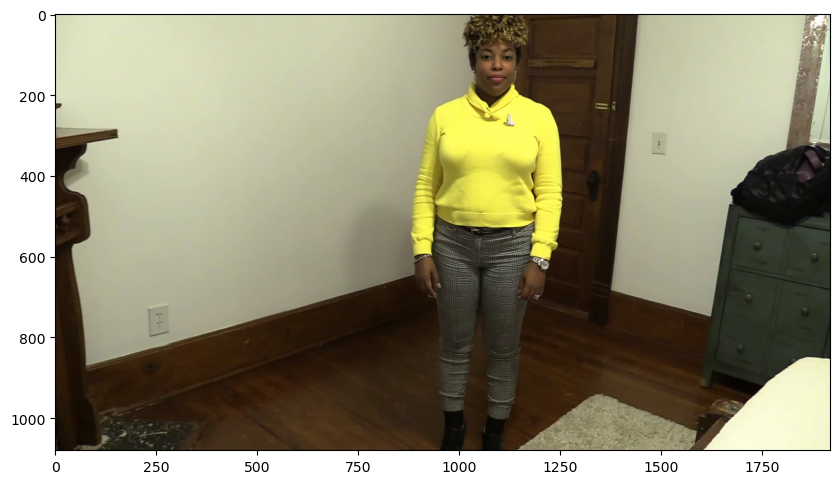

In [11]:
#for video_file in r_train_sample_video:
#capture_image_from_video(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,video_file))
capture_image_from_video('C:/Users/91995/Music/deepfake/deepfake/dataset/train_sample_videos/agqphdxmwt.mp4')

In [12]:
f_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)

In [13]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file,subset=TRAIN_SAMPLE_FOLDER):
    video_url = open(os.path.join(DATA_FOLDER,subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" %data_url)
play_video(f_videos[5])

**Modelling**

In [14]:
img_size = 224
batch_size = 64
epochs = 20

max_seq_length = 20
num_features = 2048

In [15]:
def crop_center_square(frame):
    y,x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y :start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(img_size, img_size)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while 1:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)
    

In [16]:
def pretrain_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
    weights = "imagenet",
    include_top=False,
    pooling="avg",
    input_shape = (img_size,img_size,3)
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    
    inputs = keras.Input((img_size,img_size,3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = pretrain_feature_extractor()

In [17]:
def prepare_all_videos(df, root_dir): 
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(int)
    
    frame_masks = np.zeros(shape=(num_samples, max_seq_length), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, max_seq_length, num_features), dtype="float32"
    )
    
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        temp_frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(max_seq_length, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] =feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] =1 # 1 = not masked, 0 = masked
        
        frame_features[idx,] =temp_frame_features.squeeze()
        frame_masks[idx,] =temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels

In [18]:
from sklearn.model_selection import train_test_split

Train_set , Test_set = train_test_split(train_sample_metadata, test_size=0.1,random_state=42,
                                       stratify=train_sample_metadata['label'])
print(Train_set.shape, Test_set.shape)

(360, 3) (40, 3)


In [19]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

print(f"Frame features in train set:{train_data[0].shape}")
print(f"Frame masks in train set:{train_data[1].shape}")

Frame features in train set:(360, 20, 2048)
Frame masks in train set:(360, 20)


In [20]:
frame_features_input = keras.Input((max_seq_length, num_features))
mask_input = keras.Input((max_seq_length,),dtype="bool")

x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask = mask_input)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 20, 2048)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru (GRU)                     │ (None, 20, 16)            │          99,168 │ input_layer_2[0][0],       │
│                               │                           │                 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_1 (GRU)                   │ (None, 8)                 │             624 │ gru[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 8)                 │               0 │ gru_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 8)                 │              72 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │               9 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 99,873 (390.13 KB)

 Trainable params: 99,873 (390.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
checkpoint = keras.callbacks.ModelCheckpoint('.weights.h5', save_weights_only=True, save_best_only=True)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]], test_labels),
        callbacks=[checkpoint],
        epochs=epochs,
        batch_size=8
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7475 - loss: 0.6899 - val_accuracy: 0.8000 - val_loss: 0.6810
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7867 - loss: 0.6789 - val_accuracy: 0.8000 - val_loss: 0.6699
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7960 - loss: 0.6675 - val_accuracy: 0.8000 - val_loss: 0.6592
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8306 - loss: 0.6526 - val_accuracy: 0.8000 - val_loss: 0.6486
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8138 - loss: 0.6440 - val_accuracy: 0.8000 - val_loss: 0.6390
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8227 - loss: 0.6321 - val_accuracy: 0.8000 - val_loss: 0.6299
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7972 - loss: 0.6283 - val_accuracy: 0.8000 - val_loss: 0.6211
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8448 - loss: 0.6068 - val_accuracy: 0.8000 - 

In [22]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

In [23]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
    frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(max_seq_length, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    #frames = load_video('C:/Users/91995/Music/deepfake/deepfake/dataset/test_videos/adohdulfwb.mp4')
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_videos["video"].values.tolist())
print(f"Test video path: {test_video}")

if(sequence_prediction(test_video)>=0.5):
    print(f'The predicted class of the video is FAKE')
else:
    print(f'The predicted class of the video is REAL')

play_video(test_video,TEST_FOLDER)

Test video path: btdxnajogv.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted class of the video is FAKE
